In [30]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
# Load the dataset
df = pd.read_csv('smoke_detection_iot.csv')

# Display the first five rows in a pretty table
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))


+---+------------+--------------+----------------+-------------+-----------+-----------+---------+-------------+---------------+-------+-------+-------+-------+-------+-----+------------+
|   | Unnamed: 0 |     UTC      | Temperature[C] | Humidity[%] | TVOC[ppb] | eCO2[ppm] | Raw H2  | Raw Ethanol | Pressure[hPa] | PM1.0 | PM2.5 | NC0.5 | NC1.0 | NC2.5 | CNT | Fire Alarm |
+---+------------+--------------+----------------+-------------+-----------+-----------+---------+-------------+---------------+-------+-------+-------+-------+-------+-----+------------+
| 0 |    0.0     | 1654733331.0 |      20.0      |    57.36    |    0.0    |   400.0   | 12306.0 |   18520.0   |    939.735    |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  | 0.0 |    0.0     |
| 1 |    1.0     | 1654733332.0 |     20.015     |    56.67    |    0.0    |   400.0   | 12345.0 |   18651.0   |    939.744    |  0.0  |  0.0  |  0.0  |  0.0  |  0.0  | 1.0 |    0.0     |
| 2 |    2.0     | 1654733333.0 |     20.029     |    55.96 

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(tabulate(missing_values.reset_index(), headers=["Column", "Missing Values"], tablefmt="pretty"))

# Get basic statistics for numerical columns
print("\nBasic descriptive statistics:")
print(tabulate(df.describe().reset_index(), headers="keys", tablefmt="pretty"))

# Check unique values in target column 'Fire Alarm'
print("\nUnique values in 'Fire Alarm' column:")
unique_values = df['Fire Alarm'].unique()
print(tabulate(enumerate(unique_values), headers=["Index", "Unique Value"], tablefmt="pretty"))

Missing values in each column:
+----+----------------+----------------+
|    |     Column     | Missing Values |
+----+----------------+----------------+
| 0  |   Unnamed: 0   |       0        |
| 1  |      UTC       |       0        |
| 2  | Temperature[C] |       0        |
| 3  |  Humidity[%]   |       0        |
| 4  |   TVOC[ppb]    |       0        |
| 5  |   eCO2[ppm]    |       0        |
| 6  |     Raw H2     |       0        |
| 7  |  Raw Ethanol   |       0        |
| 8  | Pressure[hPa]  |       0        |
| 9  |     PM1.0      |       0        |
| 10 |     PM2.5      |       0        |
| 11 |     NC0.5      |       0        |
| 12 |     NC1.0      |       0        |
| 13 |     NC2.5      |       0        |
| 14 |      CNT       |       0        |
| 15 |   Fire Alarm   |       0        |
+----+----------------+----------------+

Basic descriptive statistics:
+---+-------+-------------------+--------------------+--------------------+--------------------+--------------------+-

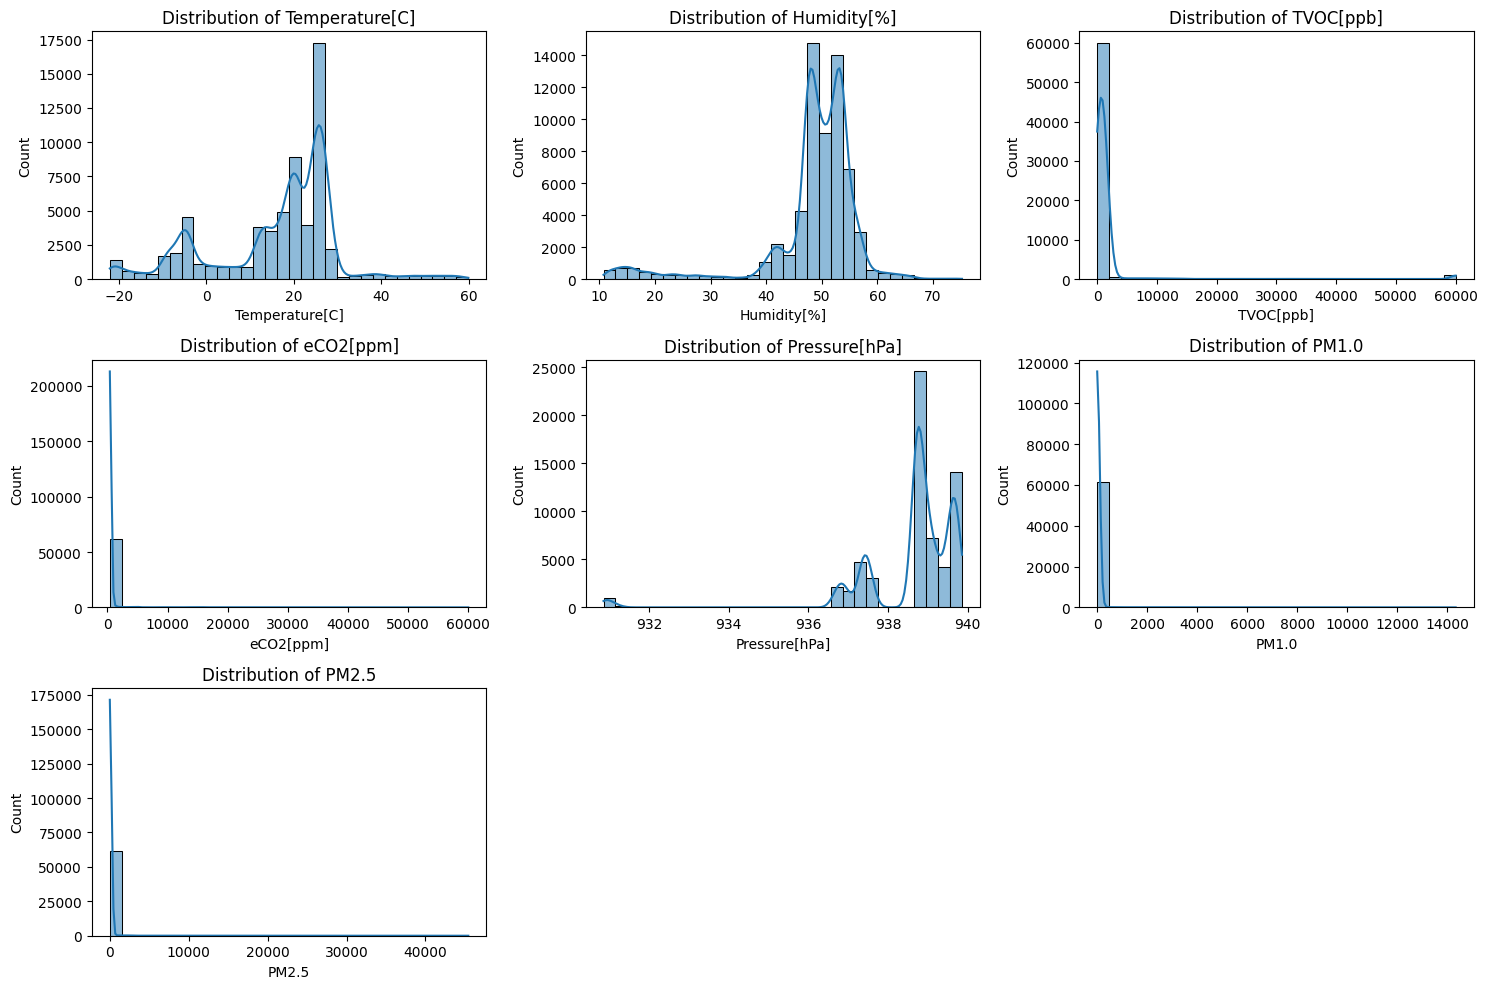

In [5]:
# Plot distributions for a few key features
features = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Pressure[hPa]', 'PM1.0', 'PM2.5']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [32]:
# Quantiles
quantiles = df[features].quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])
print("Quantiles:")
print(tabulate(quantiles, headers=quantiles.columns, tablefmt="pretty"))

# Summary Statistics
summary_stats = df[features].describe().loc[['mean', 'std']]
print("\nSummary Statistics (Mean and Standard Deviation):")
print(tabulate(summary_stats, headers=summary_stats.columns, tablefmt="pretty"))

# Skewness
skewness = df[features].skew()
print("\nSkewness of Each Feature:")
print(tabulate(skewness.reset_index(), headers=["Feature", "Skewness"], tablefmt="pretty"))

# Correlation with Target
correlation_with_target = df.corr()['Fire Alarm'].sort_values(ascending=False)
print("\nCorrelations with 'Fire Alarm':")
print(tabulate(correlation_with_target.reset_index(), headers=["Feature", "Correlation"], tablefmt="pretty"))

Quantiles:
+------+-------------------+--------------------+-----------+-------------------+---------------+--------------------+-------------------+
|      |  Temperature[C]   |    Humidity[%]     | TVOC[ppb] |     eCO2[ppm]     | Pressure[hPa] |       PM1.0        |       PM2.5       |
+------+-------------------+--------------------+-----------+-------------------+---------------+--------------------+-------------------+
| 0.0  |      -22.01       |       10.74        |    0.0    |       400.0       |    930.852    |        0.0         |        0.0        |
| 0.01 |     -21.43384     |       13.05        |    0.0    |       400.0       |    930.931    |        0.11        |       0.14        |
| 0.25 |     10.99425      |       47.53        |   130.0   |       400.0       |     938.7     |        1.28        |       1.34        |
| 0.5  |       20.13       |       50.15        |   981.0   |       400.0       |    938.816    |        1.81        |       1.88        |
| 0.75 |      25

In [7]:
# Cap outliers for specified features at the 99th percentile
outlier_features = ['TVOC[ppb]', 'eCO2[ppm]', 'PM1.0', 'PM2.5']
for feature in outlier_features:
    cap_value = df[feature].quantile(0.99)
    df[feature] = np.where(df[feature] > cap_value, cap_value, df[feature])

# Apply log transformation to reduce skewness for outlier features
for feature in outlier_features:
    df[feature] = np.log1p(df[feature])

# Log-transform additional skewed features for normalization
skewed_features = ['Raw Ethanol', 'Raw H2', 'CNT']
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])

# Create interaction features - Temperature-Humidity Ratio and Difference
df['Temp_Humidity_Ratio'] = df['Temperature[C]'] / (df['Humidity[%]'] + 1)
df['Temp_Humidity_Diff'] = df['Temperature[C]'] - df['Humidity[%]']

# Standardize numerical features to have mean = 0 and std = 1
features_to_scale = [
    'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]', 'Pressure[hPa]',
    'PM1.0', 'PM2.5', 'Raw H2', 'Raw Ethanol', 'CNT', 'Temp_Humidity_Ratio',
    'Temp_Humidity_Diff'
]
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Verify transformations and scaling
means = df[features_to_scale].mean().to_frame(name='Mean').reset_index()
stds = df[features_to_scale].std().to_frame(name='Std Deviation').reset_index()
skewness = df[features_to_scale].skew().to_frame(name='Skewness').reset_index()

print("\nFeature Means after Scaling:")
print(tabulate(means, headers=["Feature", "Mean"], tablefmt="pretty"))

print("\nFeature Standard Deviations after Scaling:")
print(tabulate(stds, headers=["Feature", "Std Deviation"], tablefmt="pretty"))

print("\nFeature Skewness after Log Transformation:")
print(tabulate(skewness, headers=["Feature", "Skewness"], tablefmt="pretty"))


Feature Means after Scaling:
+----+---------------------+-------------------------+
|    |       Feature       |          Mean           |
+----+---------------------+-------------------------+
| 0  |   Temperature[C]    | -5.808684028567321e-17  |
| 1  |     Humidity[%]     | -2.613907812855294e-16  |
| 2  |      TVOC[ppb]      | -3.4489061419618467e-16 |
| 3  |      eCO2[ppm]      | -3.162102368051335e-15  |
| 4  |    Pressure[hPa]    | -6.630612818609596e-14  |
| 5  |        PM1.0        | 2.1782565107127453e-17  |
| 6  |        PM2.5        | 2.1056479603556538e-16  |
| 7  |       Raw H2        | 5.1435897072963626e-14  |
| 8  |     Raw Ethanol     | -3.556366796490342e-14  |
| 9  |         CNT         |  9.14867734499353e-16   |
| 10 | Temp_Humidity_Ratio |  7.260855035709151e-17  |
| 11 | Temp_Humidity_Diff  | 1.4521710071418302e-16  |
+----+---------------------+-------------------------+

Feature Standard Deviations after Scaling:
+----+---------------------+------------------

In [8]:
# Ensure that 'Temp_Humidity_Ratio' is computed correctly from 'Temperature[C]' and 'Humidity[%]'
df['Temp_Humidity_Ratio'] = df['Temperature[C]'] / df['Humidity[%]']

# Log transform features that have positive skew
log_transform_features = ['TVOC[ppb]', 'PM1.0', 'PM2.5', 'Raw Ethanol', 'Raw H2', 'CNT']
for feature in log_transform_features:
    df[feature] = np.log1p(df[feature])

# Apply Box-Cox transformation to features with high skewness like 'Temp_Humidity_Ratio'
# Box-Cox requires positive values, so adding a small constant to avoid zero/negative values
if (df['Temp_Humidity_Ratio'] <= 0).any():
    df['Temp_Humidity_Ratio'] += abs(df['Temp_Humidity_Ratio'].min()) + 1

df['Temp_Humidity_Ratio'], _ = boxcox(df['Temp_Humidity_Ratio'])

# Standard Scaling all features
scaler = StandardScaler()
scaled_features = ['Temperature[C]', 'Humidity[%]', 'TVOC[ppb]', 'eCO2[ppm]',
                   'Pressure[hPa]', 'PM1.0', 'PM2.5', 'Raw H2', 'Raw Ethanol',
                   'CNT', 'Temp_Humidity_Ratio']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# Drop unnecessary features, if any (e.g., 'Unnamed: 0' or other non-relevant columns)
df.drop(columns=['Unnamed: 0', 'UTC'], inplace=True)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


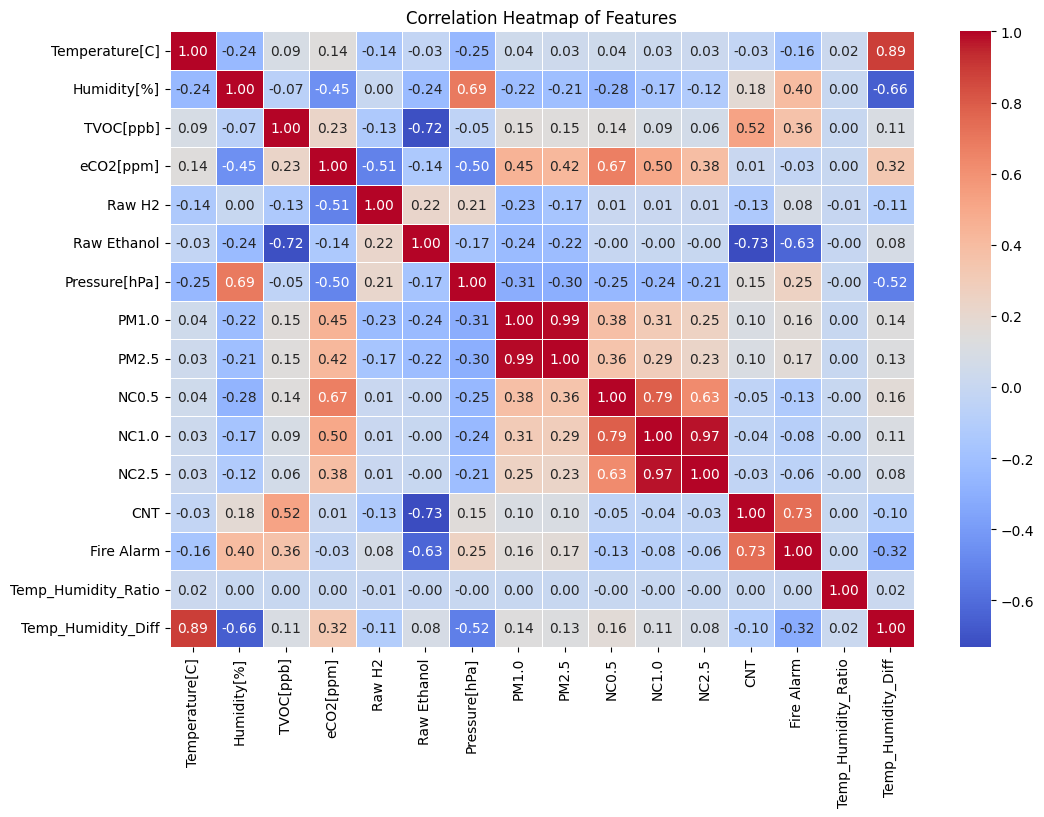

In [9]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Heatmap of Features')

# Show the plot
plt.show()


In [10]:
# Drop rows with missing values
df.dropna(inplace=True)

# split the data after dropping rows
X = df.drop(columns=['Fire Alarm'])
y = df['Fire Alarm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [11]:
# Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = conf_matrix_rf.ravel()

# Metrics Calculation
tpr_rf = tp / (tp + fn)  # True Positive Rate
fpr_rf = fp / (fp + tn)  # False Positive Rate
precision_rf = tp / (tp + fp)  # Precision
recall_rf = tp / (tp + fn)  # Recall
f1_score_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf)  # F1-Score
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)  # Matthews Correlation Coefficient
accuracy_rf = accuracy_score(y_test, y_pred_rf)  # Accuracy

# Output Metrics
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest TPR (Recall): {tpr_rf:.4f}")
print(f"Random Forest FPR: {fpr_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest F1-Score: {f1_score_rf:.4f}")
print(f"Random Forest MCC: {mcc_rf:.4f}")

# Detailed Classification Report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0000
Random Forest TPR (Recall): 1.0000
Random Forest FPR: 0.0000
Random Forest Precision: 1.0000
Random Forest F1-Score: 1.0000
Random Forest MCC: 1.0000

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



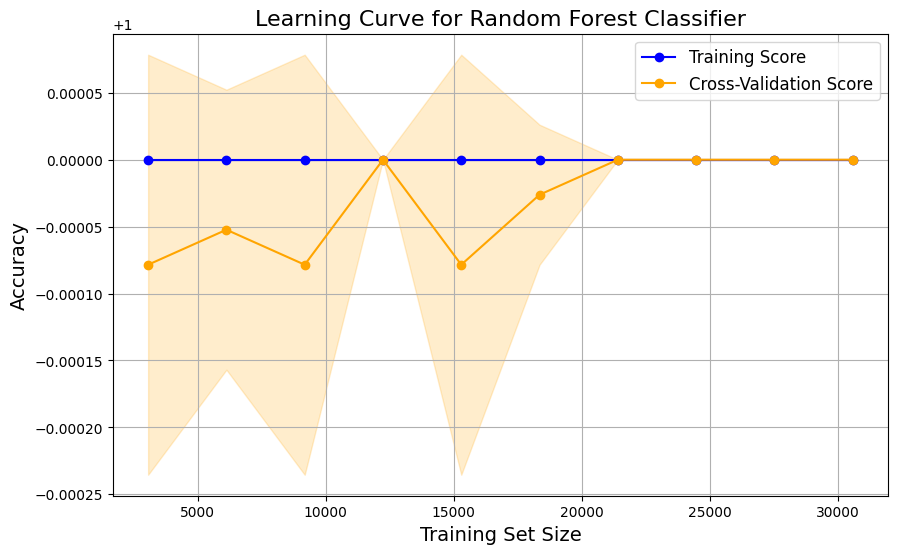

In [12]:
# Define the Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_rf,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Random Forest Classifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [13]:
# Logistic Regression
model_lr = LogisticRegression(random_state=42)

# Train the model
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = conf_matrix_lr.ravel()

# Metrics Calculation
tpr_lr = tp / (tp + fn)  # True Positive Rate
fpr_lr = fp / (fp + tn)  # False Positive Rate
precision_lr = tp / (tp + fp)  # Precision
recall_lr = tp / (tp + fn)  # Recall
f1_score_lr = 2 * (precision_lr * recall_lr) / (precision_lr + recall_lr)  # F1-Score
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)  # Matthews Correlation Coefficient
accuracy_lr = accuracy_score(y_test, y_pred_lr)  # Accuracy

# Output Metrics
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Logistic Regression TPR (Recall): {tpr_lr:.4f}")
print(f"Logistic Regression FPR: {fpr_lr:.4f}")
print(f"Logistic Regression Precision: {precision_lr:.4f}")
print(f"Logistic Regression F1-Score: {f1_score_lr:.4f}")
print(f"Logistic Regression MCC: {mcc_lr:.4f}")

# Detailed Classification Report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9998
Logistic Regression TPR (Recall): 1.0000
Logistic Regression FPR: 0.0015
Logistic Regression Precision: 0.9998
Logistic Regression F1-Score: 0.9999
Logistic Regression MCC: 0.9991

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



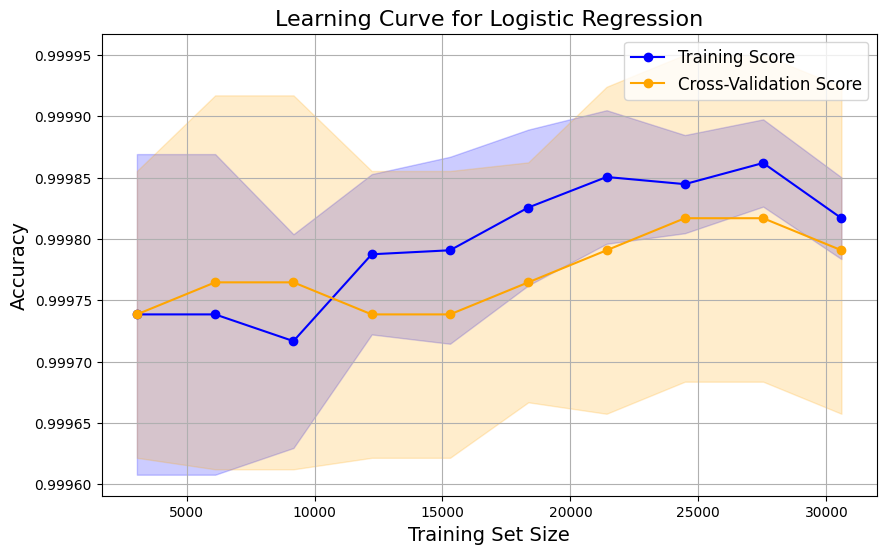

In [14]:
# Define the Logistic Regression model
model_lr = LogisticRegression(random_state=42, max_iter=1000)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_lr,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Logistic Regression', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [15]:
# Support Vector Classifier
model_svc = SVC(random_state=42)

# Train the model
model_svc.fit(X_train, y_train)

# Make predictions
y_pred_svc = model_svc.predict(X_test)

# Confusion Matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
tn, fp, fn, tp = conf_matrix_svc.ravel()

# Metrics Calculation
tpr_svc = tp / (tp + fn)  # True Positive Rate
fpr_svc = fp / (fp + tn)  # False Positive Rate
precision_svc = tp / (tp + fp)  # Precision
recall_svc = tp / (tp + fn)  # Recall
f1_score_svc = 2 * (precision_svc * recall_svc) / (precision_svc + recall_svc)  # F1-Score
mcc_svc = matthews_corrcoef(y_test, y_pred_svc)  # Matthews Correlation Coefficient
accuracy_svc = accuracy_score(y_test, y_pred_svc)  # Accuracy

# Output Metrics
print(f"SVC Accuracy: {accuracy_svc:.4f}")
print(f"SVC TPR (Recall): {tpr_svc:.4f}")
print(f"SVC FPR: {fpr_svc:.4f}")
print(f"SVC Precision: {precision_svc:.4f}")
print(f"SVC F1-Score: {f1_score_svc:.4f}")
print(f"SVC MCC: {mcc_svc:.4f}")

# Detailed Classification Report
print("\nSVC Classification Report:")
print(classification_report(y_test, y_pred_svc))


SVC Accuracy: 0.9996
SVC TPR (Recall): 0.9999
SVC FPR: 0.0023
SVC Precision: 0.9996
SVC F1-Score: 0.9998
SVC MCC: 0.9982

SVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



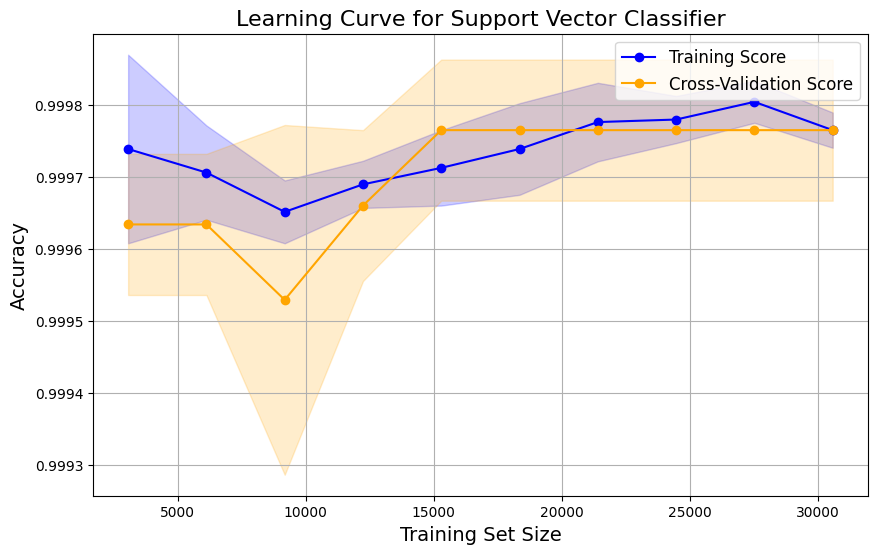

In [16]:
# Define the Support Vector Classifier model
model_svc = SVC(random_state=42)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_svc,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Support Vector Classifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [17]:
# K-Nearest Neighbors
model_knn = KNeighborsClassifier()

# Train the model
model_knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = model_knn.predict(X_test)

# Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = conf_matrix_knn.ravel()

# Metrics Calculation
tpr_knn = tp / (tp + fn)  # True Positive Rate
fpr_knn = fp / (fp + tn)  # False Positive Rate
precision_knn = tp / (tp + fp)  # Precision
recall_knn = tp / (tp + fn)  # Recall
f1_score_knn = 2 * (precision_knn * recall_knn) / (precision_knn + recall_knn)  # F1-Score
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)  # Matthews Correlation Coefficient
accuracy_knn = accuracy_score(y_test, y_pred_knn)  # Accuracy

# Output Metrics
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print(f"KNN TPR (Recall): {tpr_knn:.4f}")
print(f"KNN FPR: {fpr_knn:.4f}")
print(f"KNN Precision: {precision_knn:.4f}")
print(f"KNN F1-Score: {f1_score_knn:.4f}")
print(f"KNN MCC: {mcc_knn:.4f}")

# Detailed Classification Report
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.9997
KNN TPR (Recall): 1.0000
KNN FPR: 0.0023
KNN Precision: 0.9996
KNN F1-Score: 0.9998
KNN MCC: 0.9987

KNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



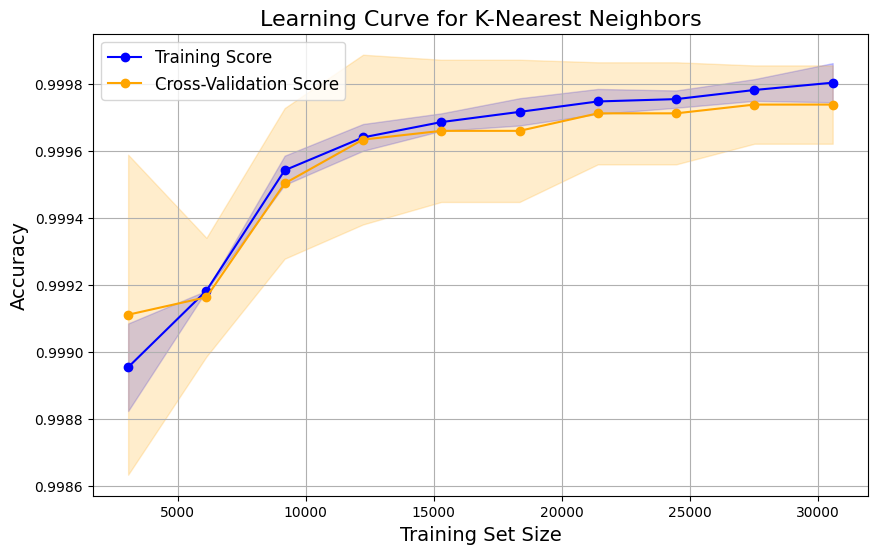

In [18]:
# Define the KNN model
model_knn = KNeighborsClassifier()

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_knn,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for K-Nearest Neighbors', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [19]:
# Decision Tree Classifier
model_dt = DecisionTreeClassifier(random_state=42)

# Train the model
model_dt.fit(X_train, y_train)

# Make predictions
y_pred_dt = model_dt.predict(X_test)

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
tn, fp, fn, tp = conf_matrix_dt.ravel()

# Metrics Calculation
tpr_dt = tp / (tp + fn)  # True Positive Rate
fpr_dt = fp / (fp + tn)  # False Positive Rate
precision_dt = tp / (tp + fp)  # Precision
recall_dt = tp / (tp + fn)  # Recall
f1_score_dt = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)  # F1-Score
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)  # Matthews Correlation Coefficient
accuracy_dt = accuracy_score(y_test, y_pred_dt)  # Accuracy

# Output Metrics
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
print(f"Decision Tree TPR (Recall): {tpr_dt:.4f}")
print(f"Decision Tree FPR: {fpr_dt:.4f}")
print(f"Decision Tree Precision: {precision_dt:.4f}")
print(f"Decision Tree F1-Score: {f1_score_dt:.4f}")
print(f"Decision Tree MCC: {mcc_dt:.4f}")

# Detailed Classification Report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 1.0000
Decision Tree TPR (Recall): 1.0000
Decision Tree FPR: 0.0000
Decision Tree Precision: 1.0000
Decision Tree F1-Score: 1.0000
Decision Tree MCC: 1.0000

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



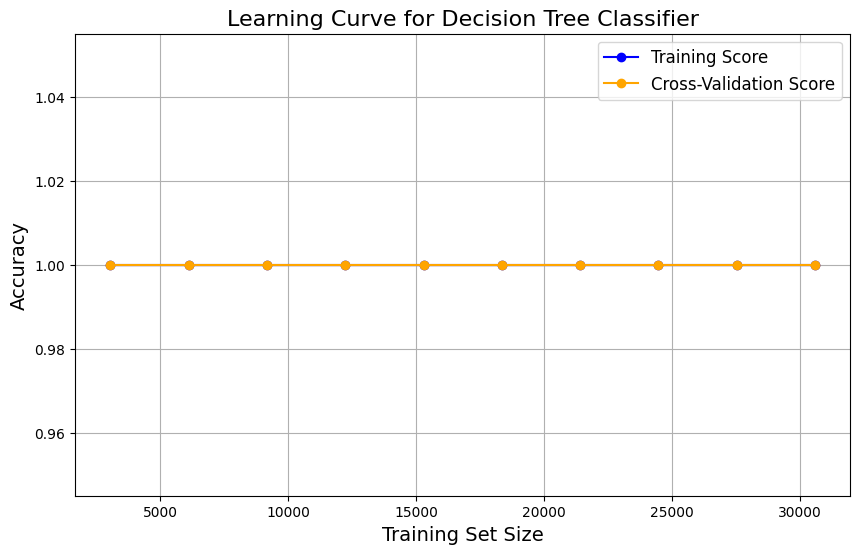

In [20]:
# Define the Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_dt,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Decision Tree Classifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [21]:
# Gradient Boosting Classifier
model_gb = GradientBoostingClassifier(random_state=42)

# Train the model
model_gb.fit(X_train, y_train)

# Make predictions
y_pred_gb = model_gb.predict(X_test)

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
tn, fp, fn, tp = conf_matrix_gb.ravel()

# Metrics Calculation
tpr_gb = tp / (tp + fn)  # True Positive Rate
fpr_gb = fp / (fp + tn)  # False Positive Rate
precision_gb = tp / (tp + fp)  # Precision
recall_gb = tp / (tp + fn)  # Recall
f1_score_gb = 2 * (precision_gb * recall_gb) / (precision_gb + recall_gb)  # F1-Score
mcc_gb = matthews_corrcoef(y_test, y_pred_gb)  # Matthews Correlation Coefficient
accuracy_gb = accuracy_score(y_test, y_pred_gb)  # Accuracy

# Output Metrics
print(f"Gradient Boosting Accuracy: {accuracy_gb:.4f}")
print(f"Gradient Boosting TPR (Recall): {tpr_gb:.4f}")
print(f"Gradient Boosting FPR: {fpr_gb:.4f}")
print(f"Gradient Boosting Precision: {precision_gb:.4f}")
print(f"Gradient Boosting F1-Score: {f1_score_gb:.4f}")
print(f"Gradient Boosting MCC: {mcc_gb:.4f}")

# Detailed Classification Report
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Accuracy: 1.0000
Gradient Boosting TPR (Recall): 1.0000
Gradient Boosting FPR: 0.0000
Gradient Boosting Precision: 1.0000
Gradient Boosting F1-Score: 1.0000
Gradient Boosting MCC: 1.0000

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      8269

    accuracy                           1.00      9560
   macro avg       1.00      1.00      1.00      9560
weighted avg       1.00      1.00      1.00      9560



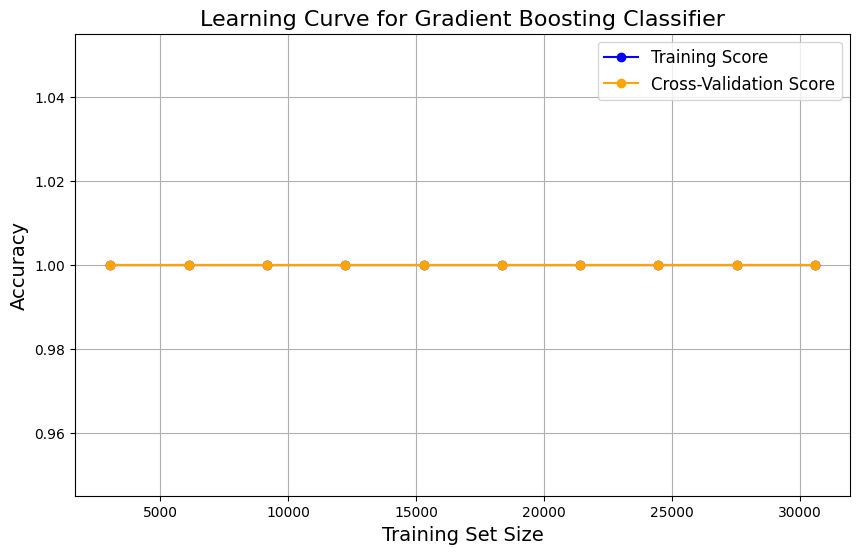

In [22]:
# Define the Gradient Boosting model
model_gb = GradientBoostingClassifier(random_state=42)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_gb,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Gradient Boosting Classifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [23]:
# Naive Bayes Classifier
model_nb = GaussianNB()

# Train the model
model_nb.fit(X_train, y_train)

# Make predictions
y_pred_nb = model_nb.predict(X_test)

# Confusion Matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
tn, fp, fn, tp = conf_matrix_nb.ravel()

# Metrics Calculation
tpr_nb = tp / (tp + fn)  # True Positive Rate
fpr_nb = fp / (fp + tn)  # False Positive Rate
precision_nb = tp / (tp + fp)  # Precision
recall_nb = tp / (tp + fn)  # Recall
f1_score_nb = 2 * (precision_nb * recall_nb) / (precision_nb + recall_nb)  # F1-Score
mcc_nb = matthews_corrcoef(y_test, y_pred_nb)  # Matthews Correlation Coefficient
accuracy_nb = accuracy_score(y_test, y_pred_nb)  # Accuracy

# Output Metrics
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"Naive Bayes TPR (Recall): {tpr_nb:.4f}")
print(f"Naive Bayes FPR: {fpr_nb:.4f}")
print(f"Naive Bayes Precision: {precision_nb:.4f}")
print(f"Naive Bayes F1-Score: {f1_score_nb:.4f}")
print(f"Naive Bayes MCC: {mcc_nb:.4f}")

# Detailed Classification Report
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.9834
Naive Bayes TPR (Recall): 0.9810
Naive Bayes FPR: 0.0015
Naive Bayes Precision: 0.9998
Naive Bayes F1-Score: 0.9903
Naive Bayes MCC: 0.9343

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1291
           1       1.00      0.98      0.99      8269

    accuracy                           0.98      9560
   macro avg       0.95      0.99      0.97      9560
weighted avg       0.99      0.98      0.98      9560



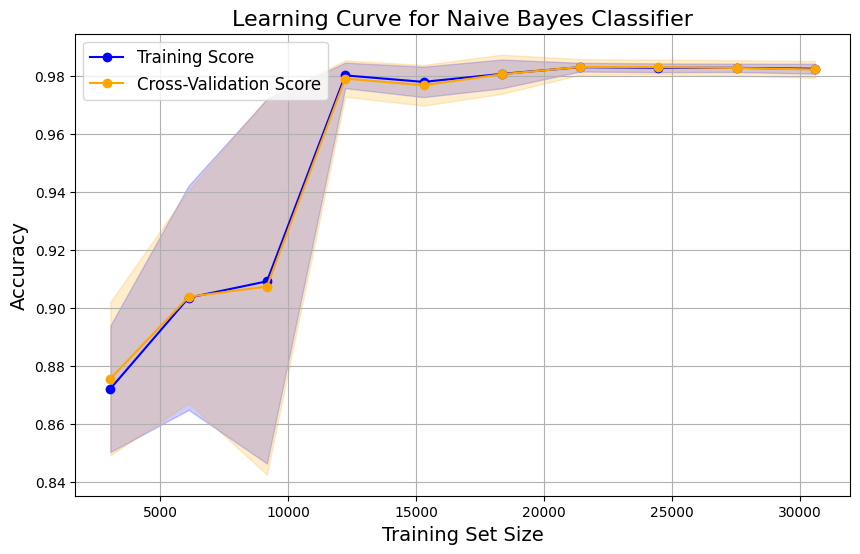

In [24]:
# Define the Naive Bayes model
model_nb = GaussianNB()

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_nb,
    X=X_train,
    y=y_train,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # Train sizes from 10% to 100% of the dataset
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score', color='orange', marker='o')
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.2)

# Add labels, legend, and title
plt.title('Learning Curve for Naive Bayes Classifier', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()


In [26]:
# Fit all models
model_rf.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_svc.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_dt.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_nb.fit(X_train, y_train)

# Calculate training accuracies for each model
accuracy_rf_train = model_rf.score(X_train, y_train)
accuracy_lr_train = model_lr.score(X_train, y_train)
accuracy_svc_train = model_svc.score(X_train, y_train)
accuracy_knn_train = model_knn.score(X_train, y_train)
accuracy_dt_train = model_dt.score(X_train, y_train)
accuracy_gb_train = model_gb.score(X_train, y_train)
accuracy_nb_train = model_nb.score(X_train, y_train)

# Store the accuracy scores for both training and testing for each model
train_accuracies = {
    'Random Forest': accuracy_rf_train,
    'Logistic Regression': accuracy_lr_train,
    'SVC': accuracy_svc_train,
    'KNN': accuracy_knn_train,
    'Decision Tree': accuracy_dt_train,
    'Gradient Boosting': accuracy_gb_train,
    'Naive Bayes': accuracy_nb_train
}

test_accuracies = {
    'Random Forest': accuracy_rf,
    'Logistic Regression': accuracy_lr,
    'SVC': accuracy_svc,
    'KNN': accuracy_knn,
    'Decision Tree': accuracy_dt,
    'Gradient Boosting': accuracy_gb,
    'Naive Bayes': accuracy_nb
}


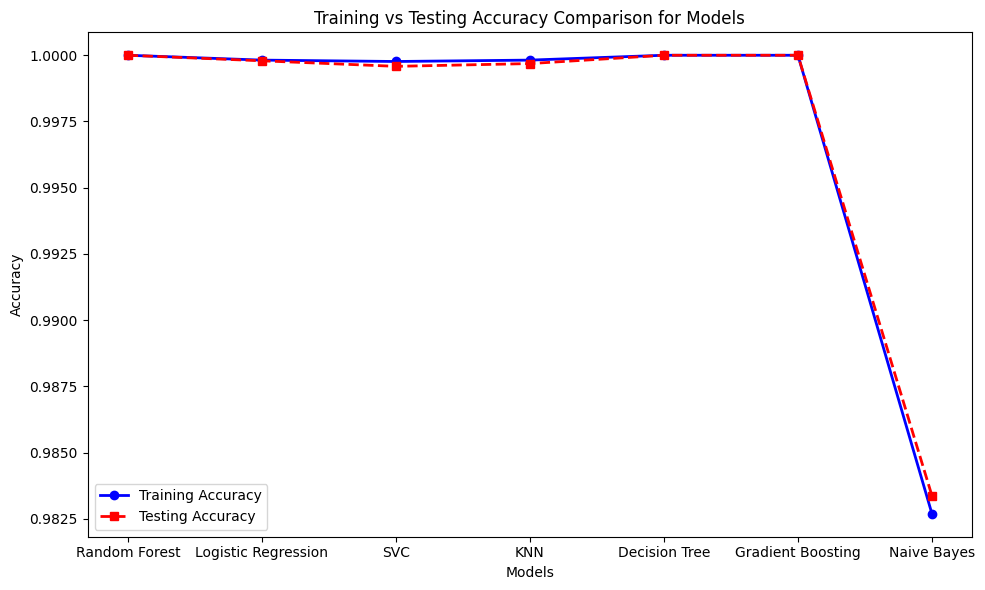

In [28]:
# Plotting Training vs Testing Accuracies
plt.figure(figsize=(10, 6))

# Plotting training accuracies
plt.plot(list(train_accuracies.keys()), list(train_accuracies.values()), marker='o', label='Training Accuracy', color='b', linestyle='-', linewidth=2)

# Plotting testing accuracies
plt.plot(list(test_accuracies.keys()), list(test_accuracies.values()), marker='s', label='Testing Accuracy', color='r', linestyle='--', linewidth=2)

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison for Models')

# Adding a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
